# Create dataset - attributes
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 05-06-2024<br>

**Introduction:**<br>
This notebook creates the table of static attributes to be used in ResOpsES.

**To do:**<br>
* [x] Add reservoir use.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import shapes
from typing import Union, List, Dict, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

from utils import plot_attributes

In [2]:
import sys
sys.path.append('../../../lisflood-utilities/src')
from lisfloodutilities.catchstats import catchment_statistics

## Configuration

In [3]:
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets')

# path to the dataset ResOpsES
PATH_RESOPSES = PATH_DATASETS / 'reservoirs' / 'ResOpsES'

# path to EFASv5
PATH_EFAS = Path('E:/casadje/Documents/EFASv5/iberia')

# paths to observed time series
PATH_HDMS = PATH_DATASETS / 'hDMS' / 'reservoirs'
PATH_HIDROSUR = PATH_DATASETS / 'Hidrosur' / 'processed' / 'reservoirs'
PATH_ACA = PATH_DATASETS / 'ACA' / 'processed' / 'reservoirs'

# minimum length of observed time series (years)
MIN_YEARS = 8

In [4]:
VERSION = '2.0'

## Base information

### Reservoirs

In [26]:
IDs = [int(file.stem) for file in (PATH_RESOPSES / f'v{VERSION}' / 'time_series' / 'netcdf').glob('*.nc')]

print(f'{len(IDs)} reservoirs with time series')

# load reservoir points
reservoirs = gpd.read_file(PATH_RESOPSES / 'GIS' / 'reservoirs_ResOpsES.shp')
reservoirs[['LAT', 'LON', 'CAP_MCM', 'CATCH_SKM']] = reservoirs[['LAT', 'LON', 'CAP_MCM', 'CATCH_SKM']].astype(float)
reservoirs['SNCZI'] = reservoirs['SNCZI'].astype(int)
reservoirs.set_index('SNCZI', inplace=True)
reservoirs = reservoirs.loc[IDs]

# identify headwater reservoirs
childs = [int(ID) for ID in reservoirs.CHILD.unique() if not np.isnan(ID)]
reservoirs['HEADWATER'] = 0
reservoirs.loc[reservoirs.index.difference(childs), 'HEADWATER'] = 1

print('{0} reservoirs and {1} attributes'.format(*reservoirs.shape))

261 reservoirs with time series
261 reservoirs and 12 attributes


###  Catchments

In [27]:
path = PATH_RESOPSES / 'ancillary' / 'cutmaps'
mask_map = 'upArea_01min.nc'

masks = {}
CATCH_SKM = {}
directories = [item for item in path.iterdir() if item.is_dir()]
for directory in tqdm(directories, desc='loading masks'):
    try:
        # reservoir ID
        ID = int(directory.stem)
        if ID not in reservoirs.index:
            print(f'Reservoir {ID} not selected')
            continue
        
        # load upstream area map
        mask = xr.open_dataset(directory / mask_map)['Band1']
        mask.name = str(ID)
        CATCH_SKM[ID] = mask.max().data

        # create and save a mask out of the previous map
        mask = xr.where(mask.notnull(), 1, mask)
        masks[ID] = mask
    except:
        print(directory)
        continue
        
# series of catchment area in km²
CATCH_SKM = pd.Series(CATCH_SKM, dtype=float, name='CATCH_SKM')
CATCH_SKM /= 1e6

loading masks:   0%|          | 0/307 [00:00<?, ?it/s]

Reservoir 165 not selected
Reservoir 234 not selected
Reservoir 254 not selected
Reservoir 257 not selected
Reservoir 328 not selected
Reservoir 342 not selected
Reservoir 351 not selected
Reservoir 369 not selected
Reservoir 556 not selected
Reservoir 616 not selected
Reservoir 623 not selected
Reservoir 659 not selected
Reservoir 725 not selected
Reservoir 793 not selected
Reservoir 856 not selected
Reservoir 866 not selected
Reservoir 918 not selected
Reservoir 971 not selected
Reservoir 1062 not selected
Reservoir 1066 not selected
Reservoir 1075 not selected
Reservoir 1078 not selected
Reservoir 1085 not selected
Reservoir 1146 not selected
Reservoir 1157 not selected
Reservoir 1255 not selected
Reservoir 1272 not selected
Reservoir 1450 not selected
Reservoir 1465 not selected
Reservoir 1764 not selected
Reservoir 1800 not selected
Reservoir 1915 not selected
Reservoir 1961 not selected
Reservoir 1964 not selected
Reservoir 2044 not selected
Reservoir 2050 not selected
Reservoir 

## Combine attributes from CEDEX, ICOLD and GRand

In [28]:
# basic geographic and dimension attributes
key_attributes = ['RES_NAME', 'LON', 'LAT', 'CAP_MCM', 'AREA_SKM', 'DAM_HGT_M', 'ELEV_MASL', 'CATCH_SKM']

In [29]:
# define reservoir uses to be included
# I've decided to use the intersection of ICOLD and GRanD uses to avoid gaps
uses_cedex = ['other', 'supply', 'fish', 'environment', 'flood', 'livestock', 'hydropower',
              'industry', 'mining', 'recreation', 'cooling', 'regulation', 'irrigation', 'diversion']
uses_icold = ['flood', 'irrigation', 'hydropower', 'fish', 'navigation',
              'recreation', 'supply', 'other', 'tailings']
uses_grand = ['irrigation', 'hydropower', 'supply', 'flood', 'recreation',
              'navigation', 'fish', 'pollution', 'livestock', 'other']
use_attributes = list(set(uses_icold).intersection(uses_grand))
use_attributes.sort()
# uses_dct = {use: index for index, use in enumerate(uses)}
# uses += ['MAIN_USE', 'SINGLE_USE']
# uses = [x.upper() for x in uses]

print(use_attributes)

['fish', 'flood', 'hydropower', 'irrigation', 'navigation', 'other', 'recreation', 'supply']


### Load data

In [33]:
# load attribute sources
sources = ['CEDEX', 'ICOLD', 'GRanD']
attributes = {source: pd.read_csv(PATH_RESOPSES / f'v{VERSION}' / 'attributes' / f'attributes_{source}.csv', index_col='reservoir_id') for source in sources}
attributes = {source: df.loc[df.index.intersection(reservoirs.index)] for source, df in attributes.items()}
attributes = {source: df[df.columns.intersection(key_attributes + use_attributes)] for source, df in attributes.items()}
for source, df in attributes.items():
    print(f'{source}: {df.shape[0]} reservoirs {df.shape[1]} attributes')

CEDEX: 257 reservoirs 15 attributes
ICOLD: 250 reservoirs 16 attributes
GRanD: 206 reservoirs 16 attributes


### Key attributes

#### Combine data sources

In [34]:
attrs_key = pd.DataFrame(index=reservoirs.index, columns=key_attributes)
attrs_key.index.name = 'reservoir_id'
for source, df in attributes.items():
    for col in df.columns.intersection(key_attributes):
        # select reservoirs missing the attribute in the combined DataFrame
        idx = df.index.intersection(attrs_key.loc[attrs_key[col].isnull()].index)
        df_sel = df.loc[idx, col]
        # remove reservoirs in the source DataFrame missing the attribute
        df_sel = df_sel.loc[~df_sel.isnull()]
        # assign values
        if df_sel.shape[0] > 0:
            print(f'{source}\t{col:9}\t{df_sel.shape[0]} reservoirs added')
            attrs_key.loc[df_sel.index, col] = df_sel

print('\nReservoir attributes missing:')
mask = attrs_key.isnull()
print(mask.sum())

# Add catchment area from EFAS
attrs_key.dropna(axis=0, how='all', inplace=True)
idx = CATCH_SKM.index.intersection(attrs_key.index)
attrs_key.loc[idx, 'CATCH_SKM'] = CATCH_SKM.loc[idx]

print('\nReservoir attributes missing:')
mask = attrs_key.isnull()
print(mask.sum())

CEDEX	RES_NAME 	257 reservoirs added
CEDEX	LON      	252 reservoirs added
CEDEX	LAT      	252 reservoirs added
CEDEX	CATCH_SKM	229 reservoirs added
CEDEX	ELEV_MASL	252 reservoirs added
CEDEX	DAM_HGT_M	252 reservoirs added
CEDEX	CAP_MCM  	257 reservoirs added
CEDEX	AREA_SKM 	256 reservoirs added
ICOLD	RES_NAME 	4 reservoirs added
ICOLD	ELEV_MASL	8 reservoirs added
ICOLD	CATCH_SKM	29 reservoirs added
ICOLD	DAM_HGT_M	8 reservoirs added
ICOLD	LON      	8 reservoirs added
ICOLD	LAT      	8 reservoirs added
ICOLD	AREA_SKM 	5 reservoirs added
ICOLD	CAP_MCM  	4 reservoirs added

Reservoir attributes missing:
RES_NAME     0
LON          1
LAT          1
CAP_MCM      0
AREA_SKM     0
DAM_HGT_M    1
ELEV_MASL    1
CATCH_SKM    3
dtype: int64

Reservoir attributes missing:
RES_NAME     0
LON          1
LAT          1
CAP_MCM      0
AREA_SKM     0
DAM_HGT_M    1
ELEV_MASL    1
CATCH_SKM    0
dtype: int64


In [35]:
cols = [col for col in key_attributes if col != 'RES_NAME']
attrs_key[cols] = attrs_key[cols].astype(float)

**Disruptivity indices**

According to Shrestha et al. (2024), the following reservoirs could be skipped from the hydrological model due to negliglible disruptivity
	49 reservoirs have a degree of regulation lower than 0.08
	88 reservoirs have a degree of disruptivity lower than 0.06 m


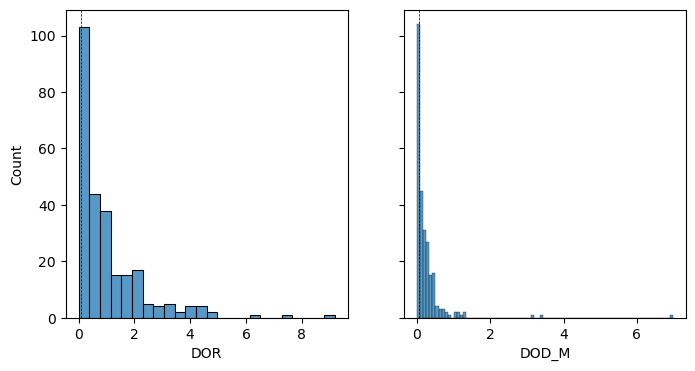

In [36]:
# degree of disruptivity (m)
attrs_key['DOD_M'] = attrs_key.CAP_MCM / attrs_key.CATCH_SKM 

# import average annual inflow (m3/s)
# avg_inflow = pd.read_csv(PATH_RESOPSES / f'v{VERSION}' / 'attributes' / 'attributes_EFAS_hydrometeorology.csv', usecols=['SNCZI', 'inflow_efas5_bc_yrmean'], index_col='SNCZI').squeeze()
avg_inflow = pd.read_csv(PATH_RESOPSES / f'v{VERSION}' / 'attributes' / 'attributes_EFAS_hydrometeorology.csv',
                         usecols=['reservoir_id', 'inflow_efas5_bc_yrmean'],
                         index_col='reservoir_id'
                        ).squeeze()
avg_inflow = avg_inflow.loc[attrs_key.index]
QIN_MCM = avg_inflow * 3600 * 24 * 365 * 1e-6

# degree of regulation (-)
attrs_key['DOR'] = attrs_key.CAP_MCM / QIN_MCM

print('According to Shrestha et al. (2024), the following reservoirs could be skipped from the hydrological model due to negliglible disruptivity')
dor_thr = 0.08
print('\t{0} reservoirs have a degree of regulation lower than {1}'.format((attrs_key.DOR < dor_thr).sum(), dor_thr))
dod_thr = 0.06
print('\t{0} reservoirs have a degree of disruptivity lower than {1} m'.format((attrs_key.DOD_M < dod_thr).sum(), dod_thr))

fig, ax = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

sns.histplot(attrs_key.DOR, ax=ax[0])
ax[0].axvline(0.08, c='k', ls='--', lw=.5)

sns.histplot(attrs_key.DOD_M, ax=ax[1])
ax[1].axvline(0.06, c='k', ls='--', lw=.5);

**Headwater reservoirs**

In [39]:
attrs_key['HEADWATER'] = reservoirs.loc[attrs_key.index, 'HEADWATER']

In [42]:
print('{0} headwater reservoirs'.format(attrs_key['HEADWATER'].sum()))

156 headwater reservoirs


#### Export

In [43]:
# export
# attrs_key.sort_index(axis=1, inplace=True)
path_attributes = PATH_RESOPSES / f'v{VERSION}' / 'attributes'
path_attributes.mkdir(parents=True, exist_ok=True)
attrs_key.to_csv(path_attributes / 'attributes_combined.csv')

### Reservoir use
#### Combine data sources

In [ ]:
attrs_use = pd.DataFrame(index=reservoirs.index, columns=use_attributes)#, dtype=float)
attrs_use.index.name = 'reservoir_id'
for source, df in attributes.items():
    for col in df.columns.intersection(use_attributes):
        # select reservoirs missing the attribute in the combined DataFrame
        idx = df.index.intersection(attrs_use.loc[attrs_use[col].isnull()].index)
        df_sel = df.loc[idx, col]
        # remove reservoirs in the source DataFrame missing the attribute
        df_sel = df_sel.loc[~df_sel.isnull()]
        # assign values
        if df_sel.shape[0] > 0:
            print(f'{source}\t{col:9}\t{df_sel.shape[0]} reservoirs added')
            attrs_use.loc[df_sel.index, col] = df_sel

print('\nReservoir attributes missing:')
mask = attrs_use.isnull()
print(mask.sum())

# fill in missing values in 'navigation'
attrs_use.dropna(axis=0, how='all', inplace=True)
attrs_use.navigation.replace(np.nan, 0, inplace=True)

# convert main use into integer classes
# attrs_use.MAIN_USE.replace(uses_dct, inplace=True)

print('\nReservoir attributes missing:')
print(attrs_use.isnull().sum())

#### Export

In [ ]:
# export
attrs_use.to_csv(path_attributes / 'attributes_use.csv')

## LISFLOOD static maps

In this section I will compute catchment statistics of the LISFLOOD static maps that will be in the end exported as _attributes_EFAS_static_maps.csv_. As ancillary maps, I will load first the pixel area and upstream area maps, that will be needed in the subsequent calculations.

In [ ]:
# load the pixel area map
pixarea = xr.open_mfdataset(f'{PATH_EFAS}/maps/pixarea*.nc')['Band1'].compute()

# load the upstream area map
upArea = xr.open_mfdataset(f'{PATH_EFAS}/maps/upArea*.nc')['Band1'].compute()

### Geomorphology

Here I will compute catchment statistics for geomorphological attributes

In [ ]:
func = {'elv': ['mean', 'std', 'min', 'max'],
        'gradient': ['mean', 'std'],
        'upArea': ['max'],
        # 'pixarea': ['sum']
       }

# load maps
geomorphology = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in func})

# compute statistics
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))

attr_geomorphology = catchment_statistics(geomorphology, masks, statistic=statistic, weight=pixarea).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_geomorphology = attr_geomorphology[cols]
# attr_geomorphology = mask_statistics(geomorphology, masks, func, weight=pixarea).to_pandas()

# plot attributes
plot_attributes(attr_geomorphology, reservoirs.geometry.x, reservoirs.geometry.y, ncols=4)

### Land use

In [ ]:
land_use

In [ ]:
attr_landuse

In [ ]:
variables = ['fracforest', 'fracirrigated', 'fracother', 'fracrice', 'fracwater', 'fracsealed']
variables.sort()

# load maps
land_use = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in variables})
land_use = land_use.rename({var: var[4:] for var in list(land_use)})

# compute statistics
attr_landuse = catchment_statistics(land_use, masks, statistic=['mean'], weight=pixarea).to_pandas()
# attr_landuse = mask_statistics(land_use, masks, func='mean', weight=pixarea).to_pandas()
attr_landuse.sort_index(axis=1, inplace=True)

# compute main land use
lu_classes = {col: i for i, col in enumerate(attr_landuse.columns, start=1)}
attr_landuse['land_use_main'] = attr_landuse.idxmax(axis=1).map(lu_classes)

# rename attributes
attr_landuse.rename(columns={col: col.split('_')[0] if 'mean' in col else col for col in attr_landuse}, inplace=True)
attr_landuse.rename(columns={col: 'frac' + col.split('_')[0] if 'mean' in col else col for col in attr_landuse}, inplace=True)

# plot attributes
plot_attributes(attr_landuse, reservoirs.geometry.x, reservoirs.geometry.y, ncols=4)

### Crop coefficient

In [ ]:
# mapping land use acronym and name
mapping_landuse = {'f': 'forest', 'i': 'irrigated', 'o': 'other'}
variables = ['cropcoef_f', 'cropcoef_i', 'cropcoef_o']

# load maps
crops = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in variables})
crops = crops.rename({var: mapping_landuse[var.split('_')[1]] for var in list(crops)})

# mean weighted by the fraction of pixel covered by each land use
crops = crops.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
crops = crops.where(~upArea.isnull())
crops.name = 'cropcoef'

# compute statistics
attr_crops = catchment_statistics(crops, masks, statistic=['mean', 'std'], weight=pixarea).to_pandas()
# attr_crops = mask_statistics(crops, masks, func=['mean', 'std']).to_pandas()

# plot attributes
plot_attributes(attr_crops, reservoirs.geometry.x, reservoirs.geometry.y, ncols=2)

### Streams

In [ ]:
func = {'chanbnkf': ['mean'],
        'chanbw': ['mean'],
        'changrad': ['mean'],
        'chanlength': ['sum'],
        'chanman': ['mean']}

# load maps
streams = {var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in func}
streams = {var: da.rename(var) for var, da in streams.items()}
streams = {var : da.drop([coord for coord in list(da.coords) if coord not in ['lon', 'lat']]) for var, da in streams.items()}
streams = xr.Dataset({var: xr.DataArray(da.data, coords=upArea.coords, name=var) for var, da in streams.items()})

# mask streams (pixels with depth larger than 1 m)
rivers = streams['chanbnkf'] > 1
# rivers.plot(cmap='Blues')
streams = streams.where(rivers)

# calcular estadístico
# attr_streams = mask_statistics(streams, masks, func).to_pandas()
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))
attr_streams = catchment_statistics(streams, masks, statistic, weight=pixarea).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_streams = attr_streams[cols]

# plot attributes
plot_attributes(attr_streams, reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)

### Soil properties

In [ ]:
variables = ['ksat', 'lambda', 'genua', 'soildepth', 'thetas', 'thetar']
layers = [1, 2, 3]
maps = [f'{var}{layer}' for var in variables for layer in layers]

# load maps
soils = {}
for var in tqdm(maps, desc='loading maps'):
    files = list((PATH_EFAS / 'maps').glob(f'{var}_*.nc'))
    if len(files) > 1:
        ds = {}
        for file in files:
            # type of land use
            cover = mapping_landuse[file.stem.split('_')[1]]
            # import map
            ds[cover] = xr.open_dataset(file)['Band1']
        ds = xr.Dataset(ds)
        da = ds.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True)
        soils[var] = da.where(~upArea.isnull())
    elif len(files) == 1:
        soils[var] = xr.open_dataset(files[0])['Band1']
soils = xr.Dataset(soils)

# compute statistics
# attr_soils = mask_statistics(soils, masks, func='mean').to_pandas()
attr_soils = catchment_statistics(soils, masks, statistic=['mean'], weight=pixarea).to_pandas()

# rename attributes
attr_soils.rename(columns={col: col.split('_')[0] for col in attr_soils if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(attr_soils, reservoirs.geometry.x, reservoirs.geometry.y, ncols=6)

### LAI

I convert the timeseries of 10-daily timesteps into annual averages.

In [ ]:
maps = ['laif', 'laii', 'laio']

# load maps
lai = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in maps})
lai = lai.rename({var: mapping_landuse[var[3]] for var in list(lai)})

# mean wheighted by the portion of pixel covered by each land use
lai = lai.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
lai = lai.where(~upArea.isnull())
lai.name = 'lai'
lai['time'] = pd.date_range('2021-01-05', periods=len(lai.time), freq='10D')

# monthly resampling
lai_m = lai.resample(time='1M').mean()
lai_m['time'] = [f'{i:02}' for i in range(1, 13)]
lai_agg = xr.Dataset({f'lai{month}': lai_m.sel(time=month).drop('time') for month in lai_m.time.data})

# annual statistics
lai_agg['laiyrmean'] = lai.mean('time')
lai_agg['laiyrmax'] = lai.max('time')
lai_agg['laiyrmin'] = lai.min('time')

# compute statistics
# attr_lai = mask_statistics(lai_agg, masks, func=['mean']).to_pandas()
attr_lai = catchment_statistics(lai_agg, masks, statistic=['mean'], weight=pixarea).to_pandas()

# rename attributes
attr_lai.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_lai if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(attr_lai, reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)

### Water demand

The original demand maps are monthly time series (domestic, energy, industry, livestock) in mm/day for the period 1990-2023. 

I will compute annual and monthly averages and from those I will compute statistics.

In [ ]:
maps = ['dom', 'ene', 'ind', 'liv']

# load maps
# demand = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')[var].compute() for var in maps})

# load maps
demand = {}
start, end = pd.to_datetime('1990-01-01'), pd.to_datetime('2023-12-31')
dates = pd.date_range(start, end, freq='D')
for use in tqdm(maps):
    
    # load dataset of demand
    da = xr.open_mfdataset(f'{PATH_EFAS}/maps/{use}_*.nc').compute()
    
    # compute cachtment statistic
    df = catchment_statistics(da, masks, statistic=['mean'], weight=pixarea)[f'{use}_mean'].to_pandas()
    
    # convert dataframe to daily resolution
    daily_df = pd.DataFrame(np.nan, index=dates, columns=df.columns)
    daily_df.index.name = 'time'
    daily_df.loc[df.index] = df

    # fill NaN
    daily_df = daily_df.ffill()
    # daily_df = daily_df.interpolate(method='linear')

    # convert to DataArray
    demand[use] = xr.Dataset.from_dataframe(daily_df).to_array(dim='id', name=use)

# combine all demands in one Dataset
demand = xr.Dataset(demand)

demand

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
for use, da in demand.items():
    da.mean('id').plot(ax=ax, lw=1, label=use)
ax.set(ylabel='demand (mm/d)',
       ylim=(-.001, None))
fig.legend();

In [ ]:
# monthly means
demand_m = demand.groupby('time.month').mean('time')

# annual mean
demand_y = demand.groupby('time.year').mean('time').mean('year')
# demand_y = demand.mean('time')

# combine in a single dataset
demand_agg = xr.Dataset()
for key, da in demand_m.items():
    for month in da.month.data:
        demand_agg[f'{key}_{month:02}'] = da.sel(month=month).drop('month')
    demand_agg[f'{key}_yr'] = demand_y[key]

# convert to volume
# demand_agg = demand_agg * 1e-3 * pixarea

# # compute statistics
# attr_demand = catchment_statistics(demand_agg, masks, statistic=['sum'], weight=pixarea).to_pandas()

# # rename attributes
# attr_demand.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_demand if 'sum' in col}, inplace=True)

attr_demand = demand_agg.to_pandas()

# plot attributes
plot_attributes(attr_demand[['dom_yr', 'ene_yr', 'ind_yr', 'liv_yr']], reservoirs.geometry.x, reservoirs.geometry.y, ncols=4)

### Reservoirs

It could be interesting to add two attributes that account for the number of reservoirs upstream and the total storage volume of those reservoirs. I can do it with the reservoirs in EFASv5, but those do not include all the reservoirs in ResOpsES (not to mention all the actual reservoirs).

In [ ]:
# load map or reservoir ID
var = 'res'
res_xr = xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')[var].compute()

# extract reservoir ID
ids = [int(id) for id in np.unique(res_xr) if not np.isnan(id)]
print('EFAS represents {0} reservoirs in the study area'.format(len(ids)))

# load table of total reservoir storage
storage_pd = pd.read_csv(PATH_EFAS.parent / 'tables' / 'rtstor.txt', sep=' ', header=None, index_col=0).squeeze().astype('int64')
storage_pd.index.name = 'ResID'
storage_pd.name = 'storage'

# create map of reservoir storage
storage = res_xr.copy(deep=True)
for id in ids:
    storage = storage.where(res_xr != id, other=storage_pd.loc[id])
# storage /= 1e6
storage.name = 'storage'
storage.attrs['units'] = 'm3'
storage.attrs['standard_name'] = 'capacity'
storage.attrs['long_name'] = 'reservoir_storage_capacity'

# compute statistics
# attr_reservoir = mask_statistics(storage, masks, func=['count', 'sum']).to_pandas()
attr_reservoir = catchment_statistics(storage, masks, statistic=['count', 'sum']).to_pandas()

# rename attributes
attr_reservoir.rename(columns={'storage_count': 'no_reservoirs', 'storage_sum': 'storage_reservoirs'}, inplace=True)

# plot attributes
plot_attributes(attr_reservoir, reservoirs.geometry.x, reservoirs.geometry.y)

### Lakes

In [ ]:
# load map or reservoir ID
var = 'lakes'
lakes_xr = xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')[var].compute()

# extract lake ID
ids = [int(id) for id in np.unique(lakes_xr) if not np.isnan(id)]
print('EFAS represents {0} lakes in the study area'.format(len(ids)))

# load table of lake area
lakes_pd = pd.read_csv(PATH_EFAS.parent / 'tables' / 'lakearea.txt', sep=' ', header=None, index_col=0).squeeze().astype('int64')
lakes_pd.index.name = 'LakeID'
lakes_pd.name = 'area'

# create map of lake area
lakearea = lakes_xr.copy(deep=True)
for id in ids:
    lakearea = lakearea.where(lakes_xr != id, other=lakes_pd.loc[id])
lakearea.name = 'area'
lakearea.attrs['units'] = 'm2'
lakearea.attrs['standard_name'] = 'area'
lakearea.attrs['long_name'] = 'lake_surface_area'

# compute statistics
# attr_lake = mask_statistics(lakearea, masks, func=['count', 'sum']).to_pandas()
attr_lake = catchment_statistics(lakearea, masks, statistic=['count', 'sum']).to_pandas()

# rename attributes
attr_lake.rename(columns={'area_count': 'no_lakes', 'area_sum': 'area_lakes'}, inplace=True)

# plot attributes
plot_attributes(attr_lake, reservoirs.geometry.x, reservoirs.geometry.y)

### Export

In [ ]:
# concatenate all attributes
attrs = pd.concat((attr_geomorphology,
                  attr_landuse,
                  attr_crops,
                  attr_streams,
                  attr_soils,
                  attr_lai,
                  attr_demand,
                  attr_reservoir,
                  attr_lake,
                 ), axis=1)
attrs.index.name = 'reservoir_id'
attrs.sort_index(axis=0, inplace=True)

print('{0} attributes define the characteristics of {1} catchments'.format(*attrs.shape[::-1]))

# export
attrs.to_csv(path_attributes / 'attributes_EFAS_static_maps.csv')

## LISFLOOD parameters

In this section I load the maps of LISFLOOD calibrated parameters an compute mean catchment values. The results are exported as a CSV file named _attributes_EFAS_model_parameters.csv_.

In [ ]:
# list of calibrated parameters in LISFLOOD
pars = {file.stem: file for file in (PATH_EFAS / 'parameters').glob('*.nc') if not file.stem.lower().startswith('efas')}
print(f'{len(pars)} parameters were calibrated in EFAS')

# load parameter maps
params = xr.Dataset({par: xr.open_dataset(file)[par].compute() for par, file in pars.items()})

# plot reservoir parameters
reservoir_parameters = ['adjust_Normal_Flood', 'ReservoirRnormqMult']
fig, axes = plt.subplots(ncols=len(reservoir_parameters), figsize=(12, 4), sharex=True, sharey=True)
for ax, par in zip(axes, reservoir_parameters):
    params[par].plot(ax=ax, add_colorbar=True, cmap='magma', cbar_kwargs={'shrink': 0.66})
    ax.scatter(reservoirs.geometry.x, reservoirs.geometry.y, s=2, c='w')
    ax.set_title(par)
    ax.set_aspect('equal')
    ax.axis('off')

# extract the pixel value of reservoir parameters
points = reservoirs[['LAT', 'LON']].to_xarray()
parameters1 = params[reservoir_parameters].sel(lat=points.LAT, lon=points.LON, method='nearest').compute()
parameters1 = parameters1.to_pandas()[reservoir_parameters]

# compute catchment statistics of the other parameters
other_parameters = list(set(list(pars)).difference(reservoir_parameters))
parameters2 = catchment_statistics(params[other_parameters], masks, statistic=['mean'], weight=pixarea).to_pandas()
parameters2.index.name = 'reservoir_id'
parameters2.sort_index(axis=0, inplace=True)
parameters2.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in parameters2 if 'mean' in col}, inplace=True)

# concatenate
parameters = pd.concat((parameters1, parameters2), axis=1)

# plot parameters
plot_attributes(parameters[reservoir_parameters], reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)
print('{0} LISFLOOD calibrated parameters have been averaged for {1} catchments'.format(*parameters.shape[::-1]))

In [ ]:
# export
parameters.to_csv(path_attributes / 'attributes_EFAS_model_parameters.csv')